In this notebook, we demonstrate the differences in latent space with and without distribution balancing. The dataset is the public dataset ISARIC, which includes 118K COVID patients from 63 countries.

In [1]:
import pickle
from plot_utils import *
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
scaler = MinMaxScaler()
#load the processed inputs (missing imputation and deindentification)
with open('processed_data.pkl', 'rb') as f:
    processed_data = pickle.load(f)
losses=[]
aurocs=[]
auprcs=[]
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
def define_tVAE(input_dimension,device,db=True):
    VAE = DisentangledVAE(number_of_labels=3,input_dimension =input_dimension ,
                          device=device)
    if db: #use Distribution Balancing --> Add disentanglement + Distribution Matching
        # Stronger KL loss helps with disentanglement
        VAE.KL_weight=5 
        #Stronger TC loss helps with disentanglement
        VAE.beta = 10
        #Add Distribution Matching
        VAE.gamma=10
    else:
        # Keep KL divergence but minimize disentanglement effect
        VAE.KL_weight=0.01
        #Remove TC loss
        VAE.beta = 0
        #Remove Distribution Matching
        VAE.gamma=0
    #standardize recon loss
    VAE.recon_weightweight = 1
    return VAE

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_data,test_data,train_label,test_label,mask = processed_data
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)
#create a validation set from training data
indices = np.random.permutation(train_data.shape[0])
training_idx, eval_idx, y_train, y_eval = train_test_split(np.arange(len(train_label)), train_label,
                                                stratify=train_label[:,0], 
                                                test_size=0.1)  

all_data = np.vstack([train_data,test_data])
t=np.hstack([train_label[:,0],test_label[:,0]])
#train a tVAE with distribution balancing
tVAE = define_tVAE(train_data.shape[1],device,db=True)
score_train,score_eval,test_score = tVAE.trainer(train_data[training_idx],
                                                test_data, train_label[training_idx],
                                                test_label,mask[training_idx], train_data[eval_idx], 
                                                train_label[eval_idx])
encoded_data = tVAE.encoder(torch.Tensor(all_data).to(tVAE.device))
treatment_DB=encoded_data[t==1,:tVAE.latent_dimension].detach().cpu().numpy()
control_DB=encoded_data[t==0,:tVAE.latent_dimension].detach().cpu().numpy()

#train a tVAE without distribution balancing
tVAE_noDB = define_tVAE(train_data.shape[1],device,db=False)
score_train,score_eval,test_score = tVAE_noDB.trainer(train_data[training_idx],
                                                test_data, train_label[training_idx],
                                                test_label,mask[training_idx], train_data[eval_idx], 
                                                train_label[eval_idx])

encoded_data = tVAE_noDB.encoder(torch.Tensor(all_data).to(tVAE_noDB.device))
treatment_noDB=encoded_data[t==1,:tVAE_noDB.latent_dimension].detach().cpu().numpy()
control_noDB=encoded_data[t==0,:tVAE_noDB.latent_dimension].detach().cpu().numpy()

epochs:   0%|          | 0/5 [00:00<?, ?it/s]

/home/bing/bing_venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/bing/bing_venv/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


epochs:   0%|          | 0/5 [00:00<?, ?it/s]

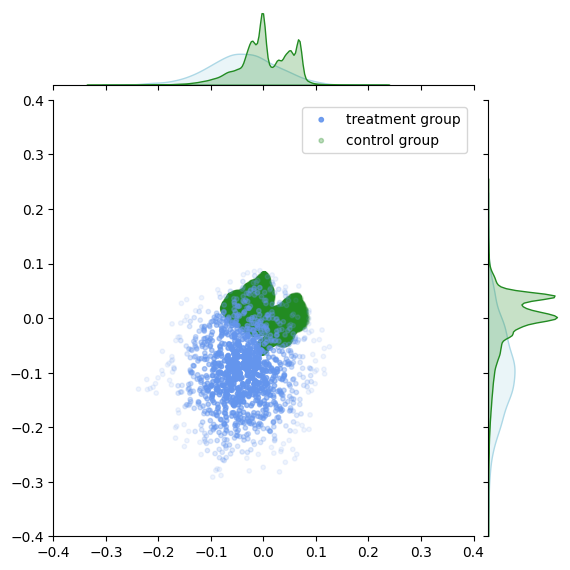

In [34]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import gaussian_kde
df1_noDB=pd.DataFrame(columns=['Without DB','Latent Dimension 5','Latent Dimension 3'])
df2_noDB=pd.DataFrame(columns=['Without DB','Latent Dimension 5','Latent Dimension 3'])
axis_limx=.4
axis_limy=.4
import matplotlib
norm = matplotlib.colors.Normalize(vmin = 0, vmax = 1, clip = False)
#select two latent dimensions for the 2D plots
latent_dimensions = [3,4]
for i,j in latent_dimensions:
    df1_noDB['Latent Dimension ' + str(j)]= control_noDB[:,j]
    df1_noDB['Latent Dimension ' + str(i)]= control_noDB[:,i]
    df1_noDB['Without DB'] = 'Control Group'
    df2_noDB['Latent Dimension ' + str(j)]= treatment_noDB[:,j]
    df2_noDB['Latent Dimension ' + str(i)]= treatment_noDB[:,i]
    df2_noDB['Without DB'] = 'Treatment Group'   
    df_noDB=pd.concat([df1_noDB,df2_noDB],axis=0)
    alpha=np.hstack([np.array([0.6]*len(df1_noDB)), np.array([0.1]*len(df2_noDB))])
    scatter_plot_nodb=sns.jointplot(data=df_noDB, x="Latent Dimension " + str(j), y="Latent Dimension " + str(i), 
                               xlim = (-1*axis_limx,axis_limx), 
                               ylim = (-1*axis_limy,axis_limy),
                               hue="Without DB", palette=['forestgreen','lightblue'], 
                               alpha=alpha,
                  marginal_kws={'common_norm':False})
    scatter_plot_nodb.ax_joint.cla()
    plt.sca(scatter_plot_nodb.ax_joint)
    #scatter plots with density
    z = gaussian_kde(treatment_noDB[:,[3,5]].T)(treatment_noDB[:,[3,5]].T)
    z=np.around(z/z.max(), decimals=1) 
    plt.scatter(treatment_noDB[:,j],treatment_noDB[:,i],
                s=10,label='treatment group',
                color='cornflowerblue',
                alpha=z,
                zorder=1
               )
    z = gaussian_kde(control_noDB[:,[3,5]].T)(control_noDB[:,[3,5]].T)
    z=np.around(z/z.max(), decimals=1) 
    plt.scatter(control_noDB[:,j],control_noDB[:,i],
                s=10,label='control group',
                color='forestgreen',
                alpha=z,
                zorder=0
               )
    plt.xlim(-1*axis_limx,axis_limx)
    plt.ylim(-1*axis_limy,axis_limy) 
    plt.legend()
    # plt.title('Without DB',y=1.08)
    plt.savefig('ISARIC_noDB.pdf')



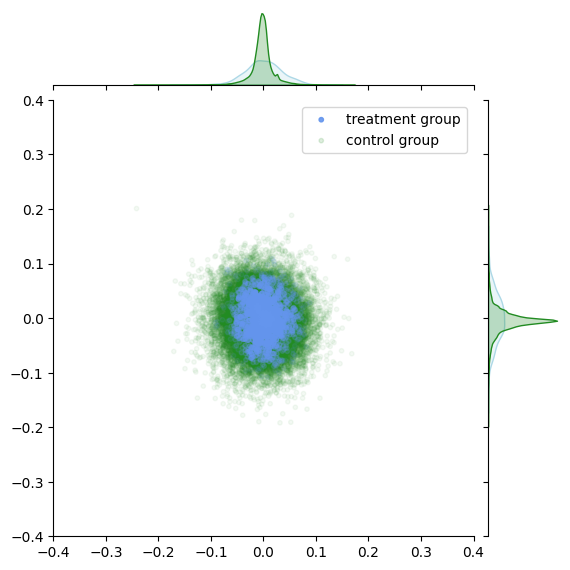

In [89]:

df1_DB=pd.DataFrame(columns=['Group','Dimension X','Dimension Y'])
df2_DB=pd.DataFrame(columns=['Group','Dimension X','Dimension Y'])

#select two latent dimensions for the 2D plots
latent_dimensions = [3,4]
for i,j in latent_dimensions:
    df1_DB['Latent Dimension ' + str(j)]= control_DB[:,j]
    df1_DB['Latent Dimension ' + str(i)]= control_DB[:,i]
    df1_DB['With DB'] = 'Control Group'
    df2_DB['Latent Dimension ' + str(j)]= treatment_DB[:,j]
    df2_DB['Latent Dimension ' + str(i)]= treatment_DB[:,i]
    df2_DB['With DB'] = 'Treatment Group'   
    df_DB=pd.concat([df1_DB,df2_DB],axis=0)
    alpha=np.hstack([np.array([0.6]*len(df1_DB)), np.array([0.2]*len(df2_DB))])
    scatter_plot=sns.jointplot(data=df_DB, x="Latent Dimension " + str(j), 
                               y="Latent Dimension " + str(i), 
                               xlim = (-1*axis_limx,axis_limx), 
                               ylim = (-1*axis_limy,axis_limy),
                  hue="With DB", palette=['forestgreen','lightblue'], 
                    alpha=alpha,
                  marginal_kws={'common_norm':False})
    scatter_plot.ax_joint.cla()
    plt.sca(scatter_plot.ax_joint)
    z1 = gaussian_kde(treatment_DB[:,[i,j]].T)(treatment_DB[:,[i,j]].T)
    z1=np.around(z1/z1.max(), decimals=1) 
    plt.scatter(treatment_DB[:,j],treatment_DB[:,i],
                s=10,label='treatment group',
                color='cornflowerblue',alpha=z1,
                zorder=0
               )
    z2 = gaussian_kde(control_DB[:,[i,j]].T)(control_DB[:,[i,j]].T)
    z2=0.05+0.95*np.around(z2/z2.max(), decimals=1) 
    plt.scatter(control_DB[:,j],control_DB[:,i],
                s=10,label='control group',
                color='forestgreen',alpha=z2,
                zorder=-1
               )
    plt.xlim(-1*axis_limx,axis_limx)
    plt.ylim(-1*axis_limy,axis_limy) 
    plt.legend()
    plt.savefig('ISARIC_DB.pdf')
